In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from holoviews.plotting.bokeh.styles import alpha
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier


import warnings
warnings.filterwarnings('ignore')


In [2]:
# importing csv
df = pd.read_csv('extractedMimic.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4559 entries, 0 to 4558
Columns: 106 entries, icustay_id to crystalloid_bolus
dtypes: float64(57), int64(39), object(10)
memory usage: 3.7+ MB


In [4]:
df.drop(df[df['age'] < 18].index, inplace=True)

df.describe()

icustay_id        hadm_id  suspected_infection_time_poe_days  \
count    4555.000000    4555.000000                        4555.000000   
mean   250637.474863  149922.364874                           0.084101   
std     28759.579721   28710.589841                           0.290748   
min    200075.000000  100003.000000                          -0.991076   
25%    225575.500000  125404.500000                          -0.075677   
50%    250984.000000  149667.000000                           0.034965   
75%    275436.000000  175042.500000                           0.157309   
max    299998.000000  199962.000000                           0.995139   

       positiveculture_poe  blood_culture_positive          age      is_male  \
count          4555.000000             4555.000000  4555.000000  4555.000000   
mean              0.136334                0.381339    65.173619     0.565971   
std               0.343180                0.485769    17.622075     0.495683   
min               0.000000                0.000000    18.020900     0.000000   
25%               0.000000                0.000000    53.784850     0.000000   
50%               0.000000                0.000000    66.591500     1.000000   
75%               0.000000                1.000000    79.540400     1.000000   
max               1.000000                1.000000    91.400000     1.000000   

        race_white   race_black  race_hispanic  ...  glucose_min1  \
count  4555.000000  4555.000000    4555.000000  ...   4525.000000   
mean      0.718771     0.086279       0.032931  ...    111.232044   
std       0.449649     0.280806       0.178475  ...     36.773707   
min       0.000000     0.000000       0.000000  ...     12.000000   
25%       0.000000     0.000000       0.000000  ...     89.000000   
50%       1.000000     0.000000       0.000000  ...    106.000000   
75%       1.000000     0.000000       0.000000  ...    127.000000   
max       1.000000     1.000000       1.000000  ...    480.000000   

        glucose_max1   glucose_mean          rrt    subject_id      hadm_id.1  \
count    4525.000000    4525.000000  4555.000000   4555.000000    4555.000000   
mean      411.037348     177.261026     0.043469  68174.064105  149922.364874   
std     14863.345644    2123.773411     0.203932  18470.812604   28710.589841   
min        57.000000      52.444444     0.000000    165.000000  100003.000000   
25%       130.000000     112.888889     0.000000  53134.000000  125404.500000   
50%       166.000000     134.000000     0.000000  68391.000000  149667.000000   
75%       217.000000     165.000000     0.000000  83771.500000  175042.500000   
max    999999.000000  142966.857100     1.000000  99982.000000  199962.000000   

        icustay_id.1   urineoutput  colloid_bolus  crystalloid_bolus  
count    4555.000000   4555.000000     508.000000        3361.000000  
mean   250637.474863   1842.618441     382.694882         645.671229  
std     28759.579721   1535.550605     134.934798         370.024064  
min    200075.000000      0.000000     150.000000         250.000000  
25%    225575.500000    897.500000     250.000000         500.000000  
50%    250984.000000   1560.000000     500.000000         500.000000  
75%    275436.000000   2460.000000     500.000000        1000.000000  
max    299998.000000  50515.000000    1000.000000       11000.000000  

[8 rows x 96 columns]

In [5]:
X = df[['urineoutput', 'lactate_min','bun_mean','sysbp_min', 'metastatic_cancer',
    'inr_max', 'age', 'sodium_max', 'aniongap_max', 'creatinine_min', 'spo2_mean',
    ]]

y = df['thirtyday_expire_flag']

In [6]:
X.dtypes

urineoutput          float64
lactate_min          float64
bun_mean             float64
sysbp_min            float64
metastatic_cancer      int64
inr_max              float64
age                  float64
sodium_max             int64
aniongap_max         float64
creatinine_min       float64
spo2_mean            float64
dtype: object

In [7]:
X.fillna(X.median(), inplace=True)

In [8]:
X.isnull().sum()

urineoutput          0
lactate_min          0
bun_mean             0
sysbp_min            0
metastatic_cancer    0
inr_max              0
age                  0
sodium_max           0
aniongap_max         0
creatinine_min       0
spo2_mean            0
dtype: int64

In [9]:
X.shape

(4555, 11)

In [28]:
# Step 3: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (3644, 11)
Testing set shape: (911, 11)


# -----------------------------------------------------------------------

# Testing Stacking

In [43]:


# Step 1: Define the parameter grid for hyperparameter tuning
param_grid = {
    # 'n_estimators': [100],
    # 'max_depth': [6],
    # 'learning_rate': [0.01, 0.1],
    # 'subsample': [1.0],
    # 'gamma': [0, 0.1, 0.2],  # Regularization parameter for tree pruning
#     'alpha': [0, 0.1, 0.2],  # L1 regularization term
#     'lambda': [1, 1.5, 2]    # L2 regularization term
    'n_estimators': [100],      # Increased number of trees for better learning
    'max_depth': [6],           # Control the depth of trees
    'learning_rate': [0.05],    # Reduced learning rate
    'subsample': [0.8],         # Control overfitting by using 80% of data for each tree
    'colsample_bytree': [0.8]   # Featu
}

# Step 2: Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic')),
    ('lr', LogisticRegression(max_iter=1000))
]

# Step 3: Define the stacking classifier with a logistic regression as the final estimator
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Step 4: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=stacking_model, param_grid={'xgb__' + k: v for k, v in param_grid.items()}, scoring='roc_auc', cv=5, verbose=1)

# Step 5: Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_stacking_model = grid_search.best_estimator_

# Make predictions on the test set
y_probs = best_stacking_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 7: Evaluate the model's performance with the default threshold of 0.8
default_threshold = 0.8  # Set the default threshold to 0.8
y_pred_default = (y_probs >= default_threshold).astype(int)
accuracy_default = accuracy_score(y_test, y_pred_default)
auc_default = roc_auc_score(y_test, y_probs)
conf_matrix_default = confusion_matrix(y_test, y_pred_default)
class_report_default = classification_report(y_test, y_pred_default)

# Print evaluation metrics for the default threshold
print(f"Default Threshold ({default_threshold:.1f}):")
print(f"Model Accuracy: {accuracy_default * 100:.5f}%")
print(f"Model AUC: {auc_default * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_default)
print("Classification Report:")
print(class_report_default)

# Step 8: Threshold tuning
# Determine the best threshold
thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Step 9: Evaluate the model's performance with the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)
accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_probs)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

# Print evaluation metrics for the best threshold
print(f"\nBest Threshold: {best_threshold:.2f}")
print("Best Threshold Performance:")
print(f"Model Accuracy: {accuracy_best * 100:.5f}%")
print(f"Model AUC: {auc_best * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_best)
print("Classification Report:")
print(class_report_best)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Default Threshold (0.8):
Model Accuracy: 83.97366%
Model AUC: 84.09910%
Confusion Matrix:
[[727   2]
 [144  38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       729
           1       0.95      0.21      0.34       182

    accuracy                           0.84       911
   macro avg       0.89      0.60      0.63       911
weighted avg       0.86      0.84      0.80       911


Best Threshold: 0.21
Best Threshold Performance:
Model Accuracy: 80.79034%
Model AUC: 84.09910%
Confusion Matrix:
[[612 117]
 [ 58 124]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       729
           1       0.51      0.68      0.59       182

    accuracy                           0.81       911
   macro avg       0.71      0.76      0.73       911
weighted avg       0.83      0.81      0.82  

In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score

# Step 1: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],  # Regularization parameter for tree pruning
    'colsample_bytree': [0.8],

}

# Step 2: Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic')),
    ('lr', LogisticRegression(max_iter=1000))
]

# Step 3: Define the stacking classifier with logistic regression as the final estimator
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Step 4: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=stacking_model, param_grid={'xgb__' + k: v for k, v in param_grid.items()}, 
                           scoring='roc_auc', cv=5, verbose=1)

# Step 5: Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_stacking_model = grid_search.best_estimator_

# Step 6: Make predictions on the test set
y_probs = best_stacking_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 7: Evaluate the model's performance with the default threshold of 0.5
y_pred_default = (y_probs >= 0.5).astype(int)
accuracy_default = accuracy_score(y_test, y_pred_default)
auc_default = roc_auc_score(y_test, y_probs)
conf_matrix_default = confusion_matrix(y_test, y_pred_default)
class_report_default = classification_report(y_test, y_pred_default)

# Print evaluation metrics for the default threshold
print("Default Threshold (0.5):")
print(f"Model Accuracy: {accuracy_default * 100:.5f}%")
print(f"Model AUC: {auc_default * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_default)
print("Classification Report:")
print(class_report_default)

# Step 8: Threshold tuning
# Determine the best threshold
thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Step 9: Evaluate the model's performance with the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)
accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_probs)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

# Print evaluation metrics for the best threshold
print(f"\nBest Threshold: {best_threshold:.2f}")
print("Best Threshold Performance:")
print(f"Model Accuracy: {accuracy_best * 100:.5f}%")
print(f"Model AUC: {auc_best * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_best)
print("Classification Report:")
print(class_report_best)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Default Threshold (0.5):
Model Accuracy: 85.40066%
Model AUC: 83.84434%
Confusion Matrix:
[[707  22]
 [111  71]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       729
           1       0.76      0.39      0.52       182

    accuracy                           0.85       911
   macro avg       0.81      0.68      0.72       911
weighted avg       0.84      0.85      0.83       911


Best Threshold: 0.22
Best Threshold Performance:
Model Accuracy: 81.11965%
Model AUC: 83.84434%
Confusion Matrix:
[[616 113]
 [ 59 123]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       729
           1       0.52      0.68      0.59       182

    accuracy                           0.81       911
   macro avg       0.72      0.76      0.73       911
weighted avg       0.83      0.81      0.82

In [29]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score

# Step 1: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],  # Regularization parameter for tree pruning
    'colsample_bytree': [0.8],
}

# Step 2: Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic')),
    ('lr', LogisticRegression(max_iter=1000))
]

# Step 3: Define the stacking classifier with logistic regression as the final estimator
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Step 4: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=stacking_model, param_grid={'xgb__' + k: v for k, v in param_grid.items()}, 
                           scoring='roc_auc', cv=5, verbose=1)

# Step 5: Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_stacking_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:")
print(grid_search.best_params_)

# Step 6: Make predictions on the test set
y_probs = best_stacking_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 7: Evaluate the model's performance with the default threshold of 0.5
y_pred_default = (y_probs >= 0.5).astype(int)
accuracy_default = accuracy_score(y_test, y_pred_default)
auc_default = roc_auc_score(y_test, y_probs)
conf_matrix_default = confusion_matrix(y_test, y_pred_default)
class_report_default = classification_report(y_test, y_pred_default)

# Print evaluation metrics for the default threshold
print("Default Threshold (0.5):")
print(f"Model Accuracy: {accuracy_default * 100:.5f}%")
print(f"Model AUC: {auc_default * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_default)
print("Classification Report:")
print(class_report_default)

# Step 8: Threshold tuning
# Determine the best threshold
thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Step 9: Evaluate the model's performance with the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)
accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_probs)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

# Print evaluation metrics for the best threshold
print(f"\nBest Threshold: {best_threshold:.2f}")
print("Best Threshold Performance:")
print(f"Model Accuracy: {accuracy_best * 100:.5f}%")
print(f"Model AUC: {auc_best * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_best)
print("Classification Report:")
print(class_report_best)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters:
{'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Default Threshold (0.5):
Model Accuracy: 85.94951%
Model AUC: 84.25361%
Confusion Matrix:
[[710  19]
 [109  73]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       729
           1       0.79      0.40      0.53       182

    accuracy                           0.86       911
   macro avg       0.83      0.69      0.73       911
weighted avg       0.85      0.86      0.84       911


Best Threshold: 0.19
Best Threshold Performance:
Model Accuracy: 79.69265%
Model AUC: 84.25361%
Confusion Matrix:
[[596 133]
 [ 52 130]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       729
           1       0.49      0.71      0.5

In [14]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score

# Step 1: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],  # Regularization parameter for tree pruning
    'colsample_bytree': [0.8],

}

# Step 2: Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic')),
    ('lr', LogisticRegression(max_iter=1000))
]

# Step 3: Define the stacking classifier with logistic regression as the final estimator
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Step 4: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=stacking_model, param_grid={'xgb__' + k: v for k, v in param_grid.items()}, 
                           scoring='roc_auc', cv=9, verbose=1)

# Step 5: Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_stacking_model = grid_search.best_estimator_

# Step 6: Make predictions on the test set
y_probs = best_stacking_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 7: Evaluate the model's performance with the default threshold of 0.5
y_pred_default = (y_probs >= 0.5).astype(int)
accuracy_default = accuracy_score(y_test, y_pred_default)
auc_default = roc_auc_score(y_test, y_probs)
conf_matrix_default = confusion_matrix(y_test, y_pred_default)
class_report_default = classification_report(y_test, y_pred_default)

# Print evaluation metrics for the default threshold
print("Default Threshold (0.5):")
print(f"Model Accuracy: {accuracy_default * 100:.5f}%")
print(f"Model AUC: {auc_default * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_default)
print("Classification Report:")
print(class_report_default)

# Step 8: Threshold tuning
# Determine the best threshold
thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Step 9: Evaluate the model's performance with the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)
accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_probs)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

# Print evaluation metrics for the best threshold
print(f"\nBest Threshold: {best_threshold:.2f}")
print("Best Threshold Performance:")
print(f"Model Accuracy: {accuracy_best * 100:.5f}%")
print(f"Model AUC: {auc_best * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_best)
print("Classification Report:")
print(class_report_best)


Fitting 9 folds for each of 12 candidates, totalling 108 fits
Default Threshold (0.5):
Model Accuracy: 85.18112%
Model AUC: 84.10136%
Confusion Matrix:
[[706  23]
 [112  70]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       729
           1       0.75      0.38      0.51       182

    accuracy                           0.85       911
   macro avg       0.81      0.68      0.71       911
weighted avg       0.84      0.85      0.83       911


Best Threshold: 0.21
Best Threshold Performance:
Model Accuracy: 80.57080%
Model AUC: 84.10136%
Confusion Matrix:
[[607 122]
 [ 55 127]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       729
           1       0.51      0.70      0.59       182

    accuracy                           0.81       911
   macro avg       0.71      0.77      0.73       911
weighted avg       0.84      0.81      0.8

In [32]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score

# Step 1: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],  # Regularization parameter for tree pruning
    'colsample_bytree': [0.8],

}

# Step 2: Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic')),
    ('lr', LogisticRegression(max_iter=1000))
]

# Step 3: Define the stacking classifier with logistic regression as the final estimator
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Step 4: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=stacking_model, param_grid={'xgb__' + k: v for k, v in param_grid.items()}, 
                           scoring='roc_auc', cv=12, verbose=1)

# Step 5: Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_stacking_model = grid_search.best_estimator_

# Step 6: Make predictions on the test set
y_probs = best_stacking_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 7: Evaluate the model's performance with the default threshold of 0.5
y_pred_default = (y_probs >= 0.5).astype(int)
accuracy_default = accuracy_score(y_test, y_pred_default)
auc_default = roc_auc_score(y_test, y_probs)
conf_matrix_default = confusion_matrix(y_test, y_pred_default)
class_report_default = classification_report(y_test, y_pred_default)

# Print evaluation metrics for the default threshold
print("Default Threshold (0.5):")
print(f"Model Accuracy: {accuracy_default * 100:.5f}%")
print(f"Model AUC: {auc_default * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_default)
print("Classification Report:")
print(class_report_default)

# Step 8: Threshold tuning
# Determine the best threshold
thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Step 9: Evaluate the model's performance with the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)
accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_probs)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

# Print evaluation metrics for the best threshold
print(f"\nBest Threshold: {best_threshold:.2f}")
print("Best Threshold Performance:")
print(f"Model Accuracy: {accuracy_best * 100:.5f}%")
print(f"Model AUC: {auc_best * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_best)
print("Classification Report:")
print(class_report_best)


Fitting 12 folds for each of 12 candidates, totalling 144 fits
Default Threshold (0.5):
Model Accuracy: 85.62020%
Model AUC: 84.30863%
Confusion Matrix:
[[710  19]
 [112  70]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.92       729
           1       0.79      0.38      0.52       182

    accuracy                           0.86       911
   macro avg       0.83      0.68      0.72       911
weighted avg       0.85      0.86      0.84       911


Best Threshold: 0.22
Best Threshold Performance:
Model Accuracy: 81.22942%
Model AUC: 84.30863%
Confusion Matrix:
[[614 115]
 [ 56 126]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       729
           1       0.52      0.69      0.60       182

    accuracy                           0.81       911
   macro avg       0.72      0.77      0.74       911
weighted avg       0.84      0.81      0.

In [11]:
# Step 1: Train the XGBoost model with hyperparameter tuning
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    booster='gbtree', 
    objective='binary:logistic', 
    n_estimators=90,      # Increased number of trees for better learning
    max_depth=6,           # Control the depth of trees
    learning_rate=0.05,    # Reduced learning rate
    subsample=0.8,         # Control overfitting by using 80% of data for each tree
    colsample_bytree=0.8,   # Feature subsampling
    gamma = 0.05,
)
xgb_model.fit(X_train, y_train)

# Step 2: Make predictions on the test set
y_pred = xgb_model.predict(X_test)  # Predicted labels (0 or 1)
y_probs = xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 3: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)  # Accuracy based on predicted labels
auc = roc_auc_score(y_test, y_probs)  # AUC based on predicted probabilities
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion matrix based on predicted labels
class_report = classification_report(y_test, y_pred)  # Classification report based on predicted labels

# Print evaluation metrics
print(f"Model Accuracy: {accuracy * 100:.5f}%")
print(f"Model AUC: {auc * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Model Accuracy: 85.51043%
Model AUC: 84.74804%
Confusion Matrix:
[[712  17]
 [115  67]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       729
           1       0.80      0.37      0.50       182

    accuracy                           0.86       911
   macro avg       0.83      0.67      0.71       911
weighted avg       0.85      0.86      0.83       911



In [11]:
# Set the base parameters
base_params = {
    'objective': 'binary:logistic',
    'n_estimators': 90,
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.05,
    'eval_metric': 'auc',
    'use_label_encoder': False
}

# Define number of runs and initialize lists to store results
n_runs = 10  # Adjust `n_runs` as needed
auc_scores = []
best_model_params = None
best_auc = 0


In [16]:
# Define the list of commonly used random states
random_states = [0, 1, 42, 123, 999]

# Initialize lists to store results
auc_scores = []
best_model_params = None
best_auc = 0


In [19]:
# Number of fits you want to run
n_runs = 50  # Adjust `n_runs` as needed

# Generate `n_runs` unique random states
np.random.seed(42)  # Seed for reproducibility of the random states list
random_states = np.random.choice(range(1000), size=n_runs, replace=False)  # Generate unique random states

# Initialize lists to store results
auc_scores = []
best_model_params = None
best_auc = 0


In [20]:
# Run the model for each random state in the list
for i, state in enumerate(random_states):
    print(f"Run {i+1}/{n_runs} with random_state={state}")
    
    # Create a new model instance with a specific random state
    model = xgb.XGBClassifier(**base_params, random_state=state)
    
    # Fit the model
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)
    
    # Predict probabilities for the test set
    test_preds = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUC score
    auc = roc_auc_score(y_test, test_preds)
    auc_scores.append(auc)
    
    # Update the best model if current AUC is higher than previous best
    if auc > best_auc:
        best_auc = auc
        best_model_params = model.get_params()


Run 1/50 with random_state=521
Run 2/50 with random_state=737
Run 3/50 with random_state=740
Run 4/50 with random_state=660
Run 5/50 with random_state=411
Run 6/50 with random_state=678
Run 7/50 with random_state=626
Run 8/50 with random_state=513
Run 9/50 with random_state=859
Run 10/50 with random_state=136
Run 11/50 with random_state=811
Run 12/50 with random_state=76
Run 13/50 with random_state=636
Run 14/50 with random_state=973
Run 15/50 with random_state=938
Run 16/50 with random_state=899
Run 17/50 with random_state=280
Run 18/50 with random_state=883
Run 19/50 with random_state=761
Run 20/50 with random_state=319
Run 21/50 with random_state=549
Run 22/50 with random_state=174
Run 23/50 with random_state=371
Run 24/50 with random_state=527
Run 25/50 with random_state=210
Run 26/50 with random_state=235
Run 27/50 with random_state=101
Run 28/50 with random_state=986
Run 29/50 with random_state=902
Run 30/50 with random_state=947
Run 31/50 with random_state=346
Run 32/50 with ran

In [21]:
# Calculate min, max, and average AUC
min_auc = np.min(auc_scores)
max_auc = np.max(auc_scores)
avg_auc = np.mean(auc_scores)

# Print the results
print("\n--- AUC Results Across Different Random States ---")
print(f"Minimum AUC: {min_auc}")
print(f"Maximum AUC: {max_auc}")
print(f"Average AUC: {avg_auc}")
print(f"Best AUC: {best_auc}")
print("\nBest Parameters for Best AUC Run:")
print(best_model_params)



--- AUC Results Across Different Random States ---
Minimum AUC: 0.8309930809930811
Maximum AUC: 0.8433802137505841
Average AUC: 0.8369752332715297
Best AUC: 0.8433802137505841

Best Parameters for Best AUC Run:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'gamma': 0.05, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 90, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 299, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method

In [22]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define a parameter grid with a range of values
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Initialize the XGBoost classifier with base objective and eval metric
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    model, param_grid, n_iter=20, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1, verbose=1
)
random_search.fit(X_train, y_train)

# Get the best parameters from the search
best_params = random_search.best_params_
print("Best parameters found: ", best_params)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [23]:
# Update base model parameters with the best found ones
model.set_params(**best_params)

# Fit the model with updated parameters on the training data
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

# Predict probabilities on the test set and calculate AUC
test_preds = model.predict_proba(X_test)[:, 1]
optimized_auc = roc_auc_score(y_test, test_preds)

print(f"Optimized AUC on the test set: {optimized_auc}")


Optimized AUC on the test set: 0.8401694327620254


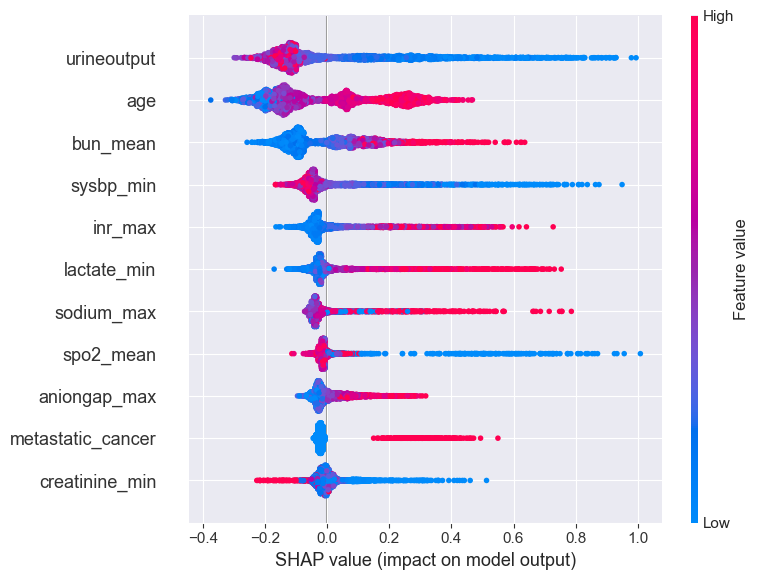

In [24]:
import shap

# Initialize SHAP explainer and compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# Plot feature importance using SHAP values
shap.summary_plot(shap_values, X_train)


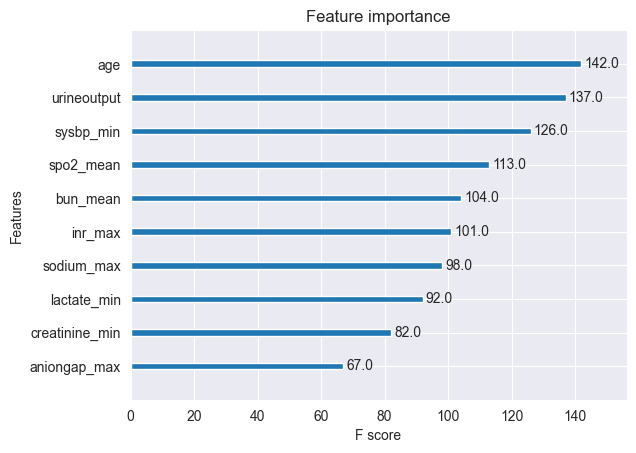

In [26]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.show()


In [30]:
# Step 1: Train the XGBoost model with hyperparameter tuning
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    booster='gbtree', 
    objective='binary:logistic', 
    n_estimators=90,      # Increased number of trees for better learning
    max_depth=6,           # Control the depth of trees
    learning_rate=0.05,    # Reduced learning rate
    subsample=0.8,         # Control overfitting by using 80% of data for each tree
    colsample_bytree=0.8,   # Feature subsampling
    gamma = 0.05,
)
xgb_model.fit(X_train, y_train)

# Step 2: Make predictions on the test set
y_pred = xgb_model.predict(X_test)  # Predicted labels (0 or 1)
y_probs = xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 3: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)  # Accuracy based on predicted labels
auc = roc_auc_score(y_test, y_probs)  # AUC based on predicted probabilities
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion matrix based on predicted labels
class_report = classification_report(y_test, y_pred)  # Classification report based on predicted labels

# Print evaluation metrics
print(f"Model Accuracy: {accuracy * 100:.5f}%")
print(f"Model AUC: {auc * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Model Accuracy: 85.51043%
Model AUC: 84.74804%
Confusion Matrix:
[[712  17]
 [115  67]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       729
           1       0.80      0.37      0.50       182

    accuracy                           0.86       911
   macro avg       0.83      0.67      0.71       911
weighted avg       0.85      0.86      0.83       911



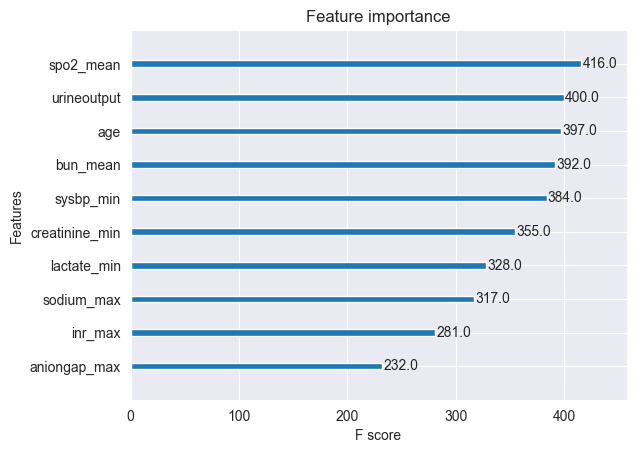

In [31]:
# Visualize feature importance based on 'weight' (how often each feature is used)
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.show()


In [32]:
# Extract feature importance from the model
importance = xgb_model.get_booster().get_score(importance_type='weight')

# Print the importance of each feature
for feature, imp in importance.items():
    print(f"Feature: {feature}, Importance: {imp}")


Feature: urineoutput, Importance: 400.0
Feature: lactate_min, Importance: 328.0
Feature: bun_mean, Importance: 392.0
Feature: sysbp_min, Importance: 384.0
Feature: metastatic_cancer, Importance: 80.0
Feature: inr_max, Importance: 281.0
Feature: age, Importance: 397.0
Feature: sodium_max, Importance: 317.0
Feature: aniongap_max, Importance: 232.0
Feature: creatinine_min, Importance: 355.0
Feature: spo2_mean, Importance: 416.0


In [33]:
# Define the odds ratios (OR) from the article (Table 3)
odds_ratios = {
    'Urineoutput': 1,
    'Lactate_min': 1.401,
    'Bun_mean': 1.018,
    'Sysbp_min': 0.979,
    'Metastatic_cancer': 2.997,
    'Inr_max': 1.058,
    'Age': 1.019,
    'Sodium_max': 1.016,
    'Aniongap_max': 1.048,
    'Creatinine_min': 0.766,
    'Spo2_mean': 0.897
}

# Convert OR to log(OR)
log_odds_ratios = {feature: np.log(or_value) for feature, or_value in odds_ratios.items()}

# Print the log(OR) values for comparison
for feature, log_or in log_odds_ratios.items():
    print(f"Feature: {feature}, Log(OR): {log_or}")


Feature: Urineoutput, Log(OR): 0.0
Feature: Lactate_min, Log(OR): 0.33718626735486995
Feature: Bun_mean, Log(OR): 0.017839918128331016
Feature: Sysbp_min, Log(OR): -0.021223636451626688
Feature: Metastatic_cancer, Log(OR): 1.0976117883345262
Feature: Inr_max, Log(OR): 0.05638033343610769
Feature: Age, Log(OR): 0.018821754240587667
Feature: Sodium_max, Log(OR): 0.015873349156290163
Feature: Aniongap_max, Log(OR): 0.04688358589885046
Feature: Creatinine_min, Log(OR): -0.26657310924154576
Feature: Spo2_mean, Log(OR): -0.10869941692334091


In [34]:
# Combine XGBoost feature importance and log(OR) into a DataFrame
feature_names = list(importance.keys())
xgb_importance_values = list(importance.values())
log_odds_values = [log_odds_ratios.get(feature, 0) for feature in feature_names]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost Importance': xgb_importance_values,
    'Log(OR) from Article': log_odds_values
})

# Sort the DataFrame by XGBoost Importance for better comparison
comparison_df = comparison_df.sort_values(by='XGBoost Importance', ascending=False)
print(comparison_df)


              Feature  XGBoost Importance  Log(OR) from Article
10          spo2_mean               416.0                     0
0         urineoutput               400.0                     0
6                 age               397.0                     0
2            bun_mean               392.0                     0
3           sysbp_min               384.0                     0
9      creatinine_min               355.0                     0
1         lactate_min               328.0                     0
7          sodium_max               317.0                     0
5             inr_max               281.0                     0
8        aniongap_max               232.0                     0
4   metastatic_cancer                80.0                     0


In [35]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import optuna
import warnings
warnings.filterwarnings('ignore')

def optimize_xgboost(trial, X, y):
    """Optuna objective function for XGBoost optimization"""
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'alpha': trial.suggest_float('alpha', 0, 10),
        'lambda': trial.suggest_float('lambda', 1, 10),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        model = xgb.XGBClassifier(
            **param,
            use_label_encoder=False,
            eval_metric='auc',
            objective='binary:logistic',
            random_state=42
        )
        model.fit(X_train_fold, y_train_fold,
                 eval_set=[(X_val_fold, y_val_fold)],
                 early_stopping_rounds=50,
                 verbose=False)
        
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        fold_score = roc_auc_score(y_val_fold, y_pred_proba)
        cv_scores.append(fold_score)
    
    return np.mean(cv_scores)

def train_optimized_xgboost(X_train, X_test, y_train, y_test):
    """Train and evaluate an optimized XGBoost model"""
    
    # Convert to numpy arrays if they aren't already
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    # Optimize hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: optimize_xgboost(trial, X_train_balanced, y_train_balanced),
                  n_trials=50, show_progress_bar=True)
    
    # Get the best parameters
    best_params = study.best_params
    print("Best hyperparameters:", best_params)
    
    # Train final model with best parameters
    final_model = xgb.XGBClassifier(
        **best_params,
        use_label_encoder=False,
        eval_metric='auc',
        objective='binary:logistic',
        random_state=42
    )
    
    # Train with early stopping
    final_model.fit(X_train_balanced, y_train_balanced,
                   eval_set=[(X_test_scaled, y_test)],
                   early_stopping_rounds=50,
                   verbose=False)
    
    # Make predictions
    y_pred = final_model.predict(X_test_scaled)
    y_probs = final_model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"\nModel Accuracy: {accuracy * 100:.5f}%")
    print(f"Model AUC: {auc * 100:.5f}%")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    
    # Return the model and metrics
    return {
        'model': final_model,
        'best_params': best_params,
        'metrics': {
            'accuracy': accuracy,
            'auc': auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
    }

# Usage example:
# results = train_optimized_xgboost(X_train, X_test, y_train, y_test)

In [36]:
results = train_optimized_xgboost(X_train, X_test, y_train, y_test)

# Access the trained model
model = results['model']

# Access the best parameters found
best_params = results['best_params']

# Access the performance metrics
metrics = results['metrics']

[I 2024-11-10 21:03:48,977] A new study created in memory with name: no-name-47238b9e-dfec-4770-9342-23a50473cdcb


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-10 21:03:51,679] Trial 0 finished with value: 0.9581029445583239 and parameters: {'max_depth': 7, 'learning_rate': 0.2942380516189231, 'n_estimators': 199, 'min_child_weight': 6, 'subsample': 0.7075503895337021, 'colsample_bytree': 0.7681465876765208, 'gamma': 0.17970433148972392, 'alpha': 5.628174722062379, 'lambda': 6.92460394186768}. Best is trial 0 with value: 0.9581029445583239.
[I 2024-11-10 21:03:54,194] Trial 1 finished with value: 0.9630940979226352 and parameters: {'max_depth': 8, 'learning_rate': 0.043173745385608885, 'n_estimators': 222, 'min_child_weight': 1, 'subsample': 0.7439789742569967, 'colsample_bytree': 0.9671296870214845, 'gamma': 0.4958987735737132, 'alpha': 0.8974128488403654, 'lambda': 3.4022087422379914}. Best is trial 1 with value: 0.9630940979226352.
[I 2024-11-10 21:03:55,049] Trial 2 finished with value: 0.9329355678114748 and parameters: {'max_depth': 9, 'learning_rate': 0.04731437762880232, 'n_estimators': 77, 'min_child_weight': 3, 'subsample

In [38]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
import optuna
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

class AdvancedModelOptimizer:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.feature_importances = None
        self.best_features = None
        self.scaler = None
        self.power_transformer = None
        self.pca = None
        self.poly_features = None
        
    def create_feature_interactions(self, X):
        """Create interaction features between most important numerical features"""
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        return poly.fit_transform(X)

    def engineer_features(self, X):
        """Advanced feature engineering"""
        X_new = X.copy()
        
        # Create statistical features
        if isinstance(X_new, pd.DataFrame):
            X_new = X_new.values
            
        # Add statistical moments
        X_new = np.column_stack([
            X_new,
            np.mean(X_new, axis=1).reshape(-1, 1),
            np.std(X_new, axis=1).reshape(-1, 1),
            np.median(X_new, axis=1).reshape(-1, 1),
            np.max(X_new, axis=1).reshape(-1, 1),
            np.min(X_new, axis=1).reshape(-1, 1),
            np.percentile(X_new, 25, axis=1).reshape(-1, 1),
            np.percentile(X_new, 75, axis=1).reshape(-1, 1)
        ])
        
        return X_new

    def optimize_model(self, trial, X, y):
        """Optuna objective function for model optimization"""
        param_xgb = {
            'max_depth': trial.suggest_int('xgb_max_depth', 3, 12),
            'learning_rate': trial.suggest_float('xgb_lr', 0.005, 0.3),
            'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 500),
            'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 7),
            'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('xgb_gamma', 0, 0.5),
            'alpha': trial.suggest_float('xgb_alpha', 0, 10),
            'lambda': trial.suggest_float('xgb_lambda', 1, 10),
            'scale_pos_weight': trial.suggest_float('xgb_scale_pos_weight', 1, 10)
        }
        
        param_lgb = {
            'num_leaves': trial.suggest_int('lgb_num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('lgb_lr', 0.005, 0.3),
            'n_estimators': trial.suggest_int('lgb_n_estimators', 100, 500),
            'min_child_samples': trial.suggest_int('lgb_min_child_samples', 5, 100),
            'subsample': trial.suggest_float('lgb_subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('lgb_colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('lgb_reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('lgb_reg_lambda', 1, 10)
        }
        
        param_cb = {
            'depth': trial.suggest_int('cb_depth', 3, 12),
            'learning_rate': trial.suggest_float('cb_lr', 0.005, 0.3),
            'iterations': trial.suggest_int('cb_iterations', 100, 500),
            'l2_leaf_reg': trial.suggest_float('cb_l2_leaf_reg', 1, 10),
            'subsample': trial.suggest_float('cb_subsample', 0.6, 1.0),
            'colsample_bylevel': trial.suggest_float('cb_colsample_bylevel', 0.6, 1.0)
        }
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        cv_scores = []
        
        for train_idx, val_idx in cv.split(X, y):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            # Create base models
            xgb_model = xgb.XGBClassifier(**param_xgb, random_state=self.random_state)
            lgb_model = lgb.LGBMClassifier(**param_lgb, random_state=self.random_state)
            cb_model = cb.CatBoostClassifier(**param_cb, random_state=self.random_state, verbose=False)
            
            # Create voting classifier
            voting_clf = VotingClassifier(
                estimators=[
                    ('xgb', xgb_model),
                    ('lgb', lgb_model),
                    ('cb', cb_model)
                ],
                voting='soft'
            )
            
            # Train ensemble
            voting_clf.fit(X_train_fold, y_train_fold)
            
            # Predict probabilities
            y_pred_proba = voting_clf.predict_proba(X_val_fold)[:, 1]
            fold_score = roc_auc_score(y_val_fold, y_pred_proba)
            cv_scores.append(fold_score)
        
        return np.mean(cv_scores)

    def fit_transform(self, X_train, X_test, y_train):
        """Preprocess and transform features"""
        # Scale features
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Apply power transformer for normalization
        self.power_transformer = PowerTransformer()
        X_train_powered = self.power_transformer.fit_transform(X_train_scaled)
        X_test_powered = self.power_transformer.transform(X_test_scaled)
        
        # Engineer features
        X_train_engineered = self.engineer_features(X_train_powered)
        X_test_engineered = self.engineer_features(X_test_powered)
        
        # Apply PCA for additional features
        self.pca = PCA(n_components=0.95)  # Preserve 95% of variance
        X_train_pca = self.pca.fit_transform(X_train_powered)
        X_test_pca = self.pca.transform(X_test_powered)
        
        # Combine original and PCA features
        X_train_final = np.hstack([X_train_engineered, X_train_pca])
        X_test_final = np.hstack([X_test_engineered, X_test_pca])
        
        # Handle imbalanced data using SMOTE-Tomek
        smotetomek = SMOTETomek(random_state=self.random_state)
        X_train_balanced, y_train_balanced = smotetomek.fit_resample(X_train_final, y_train)
        
        return X_train_balanced, X_test_final, y_train_balanced

    def train_optimized_ensemble(self, X_train, X_test, y_train, y_test):
        """Train and evaluate the optimized ensemble model"""
        # Preprocess and transform features
        X_train_processed, X_test_processed, y_train_processed = self.fit_transform(X_train, X_test, y_train)
        
        # Optimize hyperparameters
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: self.optimize_model(trial, X_train_processed, y_train_processed),
                      n_trials=50, show_progress_bar=True)
        
        # Get best parameters
        best_params = study.best_params
        print("Best hyperparameters:", best_params)
        
        # Create final models with best parameters
        xgb_final = xgb.XGBClassifier(
            max_depth=best_params['xgb_max_depth'],
            learning_rate=best_params['xgb_lr'],
            n_estimators=best_params['xgb_n_estimators'],
            min_child_weight=best_params['xgb_min_child_weight'],
            subsample=best_params['xgb_subsample'],
            colsample_bytree=best_params['xgb_colsample_bytree'],
            gamma=best_params['xgb_gamma'],
            alpha=best_params['xgb_alpha'],
            lambda_=best_params['xgb_lambda'],
            scale_pos_weight=best_params['xgb_scale_pos_weight'],
            random_state=self.random_state
        )
        
        lgb_final = lgb.LGBMClassifier(
            num_leaves=best_params['lgb_num_leaves'],
            learning_rate=best_params['lgb_lr'],
            n_estimators=best_params['lgb_n_estimators'],
            min_child_samples=best_params['lgb_min_child_samples'],
            subsample=best_params['lgb_subsample'],
            colsample_bytree=best_params['lgb_colsample_bytree'],
            reg_alpha=best_params['lgb_reg_alpha'],
            reg_lambda=best_params['lgb_reg_lambda'],
            random_state=self.random_state
        )
        
        cb_final = cb.CatBoostClassifier(
            depth=best_params['cb_depth'],
            learning_rate=best_params['cb_lr'],
            iterations=best_params['cb_iterations'],
            l2_leaf_reg=best_params['cb_l2_leaf_reg'],
            subsample=best_params['cb_subsample'],
            colsample_bylevel=best_params['cb_colsample_bylevel'],
            random_state=self.random_state,
            verbose=False
        )
        
        # Create final voting classifier
        final_ensemble = VotingClassifier(
            estimators=[
                ('xgb', xgb_final),
                ('lgb', lgb_final),
                ('cb', cb_final)
            ],
            voting='soft'
        )
        
        # Train final ensemble
        final_ensemble.fit(X_train_processed, y_train_processed)
        
        # Make predictions
        y_pred = final_ensemble.predict(X_test_processed)
        y_probs = final_ensemble.predict_proba(X_test_processed)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_probs)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        
        # Print evaluation metrics
        print(f"\nModel Accuracy: {accuracy * 100:.5f}%")
        print(f"Model AUC: {auc * 100:.5f}%")
        print("\nConfusion Matrix:")
        print(conf_matrix)
        print("\nClassification Report:")
        print(class_report)
        
        return {
            'model': final_ensemble,
            'best_params': best_params,
            'metrics': {
                'accuracy': accuracy,
                'auc': auc,
                'confusion_matrix': conf_matrix,
                'classification_report': class_report
            }
        }

# Usage example:
# optimizer = AdvancedModelOptimizer()
# results = optimizer.train_optimized_ensemble(X_train, X_test, y_train, y_test)

In [39]:
# Initialize the optimizer
optimizer = AdvancedModelOptimizer()

# Train and evaluate the model
results = optimizer.train_optimized_ensemble(X_train, X_test, y_train, y_test)

# Access the trained model
model = results['model']

# Access the best parameters
best_params = results['best_params']

# Access the performance metrics
metrics = results['metrics']

[I 2024-11-10 21:10:27,339] A new study created in memory with name: no-name-d47d71e1-e5d7-4aa8-836a-d7e4cf3916cd


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2343, number of negative: 2343
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6887
[LightGBM] [Info] Number of data points in the train set: 4686, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 